## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
from torch.nn import functional as thf
import torchvision as tv

## Config

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_shape = (1, 28, 28)
latent_size = 20
hidden_size = 400
num_epochs = 15
batch_size = 128
learning_rate = 0.001


Using cuda


## MNIST Dataset

In [0]:
def create_loader(dataset):
  return th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True)

train_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=tv.transforms.ToTensor(),
    download=True)

test_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=False, transform=tv.transforms.ToTensor(),
    download=True)

train_loader = create_loader(train_ds)
test_loader = create_loader(test_ds)

In [4]:
# Split dataset by class and create loader for each.
def split_by_class(dataset, labels):
  ds_by_class = []
  for i in range(10):
    idx = np.squeeze(np.where(labels == i))
    ds = th.utils.data.dataset.Subset(dataset, idx)
    ds_by_class.append(ds)
  return ds_by_class

train_ds_by_class = split_by_class(train_ds, train_ds.train_labels)
train_loader_by_class = [create_loader(ds) for ds in train_ds_by_class]

test_ds_by_class = split_by_class(test_ds, test_ds.test_labels)
test_loader_by_class = [create_loader(ds) for ds in test_ds_by_class]

print([len(ds) for ds in train_ds_by_class])
print([len(ds) for ds in test_ds_by_class])

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


In [5]:
for x, y in train_loader_by_class[0]:
  print(x.shape, y.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128])


## Model

In [0]:
class VAE(nn.Module):
  def __init__(self, h_dim, z_dim):
    super(VAE, self).__init__()
    self.enc_h = nn.Sequential(
        nn.Conv2d(1, 4, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(4, 16, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        #nn.Conv2d(8, 16, 5, stride=2, padding=2),
        #nn.Conv2d(16, 32, 5, stride=2, padding=2),
        
        nn.Conv2d(16, 64, 4),
        nn.LeakyReLU(),
    )
    h_dim = 64
    image_size = int(np.prod(image_shape))
    self.enc_mu = nn.Linear(h_dim, z_dim)
    self.enc_logvar = nn.Linear(h_dim, z_dim)
    self.dec_h = nn.Linear(z_dim, h_dim)
    self.dec = nn.Sequential(
        nn.ConvTranspose2d(64, 16, 4),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(4, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(4, 1, 5, padding=2),
        nn.Sigmoid(),
    )
    
  def encode(self, x):
    h = thf.relu(self.enc_h(x))
    h = h.view(h.shape[0], -1)
    return self.enc_mu(h), self.enc_logvar(h)
  
  def decode(self, z):
    h = self.dec_h(z)
    h = h.view(h.shape[0], -1, 1 , 1)
    x_reconst = self.dec(h)
    return x_reconst
  
  def decode_np(self, z_np):
    if z_np.ndim < 4:
      np.expand_dims(z_np, axis=0)
    z = th.from_numpy(z_np).to(device)
    return self.decode(z)
  
  def sample_normal(self, mu, logvar):
    std = th.exp(logvar / 2)
    x = th.randn_like(std)
    return mu + x * std
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.sample_normal(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar

## Train

In [0]:
import collections
import copy

class ModelSnapshots(object):
  def __init__(self):
    self._snapshots = collections.OrderedDict()

  def snapshot(self, model, key):
    self._snapshots[key] = copy.deepcopy(model)
    
  def get(self, key):
    return self._snapshots[key]

In [0]:
def train(model, data_loader):
  model_snapshots = ModelSnapshots()
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

  num_steps = len(data_loader)
  for epoch in range(num_epochs):
    for step, (x, _) in enumerate(data_loader):
      x = x.to(device)
      x_reconst, mu, logvar = model(x)

      # Compute reconstruction loss and KL-divergence.
      # See Appendix B in VAE paper.
      reconst_loss = thf.binary_cross_entropy(x_reconst, x, size_average=False)
      kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Backprop.
      loss = reconst_loss + kl_div
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Reconst loss: {reconst_loss.item():.4f}, '
          f'KL Div: {kl_div.item():.4f}')
    model_snapshots.snapshot(model, epoch)
  return model_snapshots

In [9]:
models_by_class = [VAE(hidden_size, latent_size).to(device) for _ in range(10)]

for i in range(10):
  print(f'---- Training class {i} ----')
  train(models_by_class[i], train_loader_by_class[i])

---- Training class 0 ----


/usr/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [1/15], Reconst loss: 14321.3252, KL Div: 114.1031
Epoch [2/15], Reconst loss: 9479.4639, KL Div: 127.3799
Epoch [3/15], Reconst loss: 8291.9238, KL Div: 131.0223
Epoch [4/15], Reconst loss: 6856.1357, KL Div: 304.3381
Epoch [5/15], Reconst loss: 6441.2725, KL Div: 227.2301
Epoch [6/15], Reconst loss: 5426.6685, KL Div: 349.3915
Epoch [7/15], Reconst loss: 5500.0742, KL Div: 377.8207
Epoch [8/15], Reconst loss: 5185.1221, KL Div: 380.0163
Epoch [9/15], Reconst loss: 4315.0586, KL Div: 419.7713
Epoch [10/15], Reconst loss: 4321.1631, KL Div: 410.4264
Epoch [11/15], Reconst loss: 4440.7578, KL Div: 457.4499
Epoch [12/15], Reconst loss: 4385.7783, KL Div: 447.3277
Epoch [13/15], Reconst loss: 3879.1855, KL Div: 447.9117
Epoch [14/15], Reconst loss: 4231.7485, KL Div: 452.6028
Epoch [15/15], Reconst loss: 3997.6301, KL Div: 455.3467
---- Training class 1 ----
Epoch [1/15], Reconst loss: 31918.4434, KL Div: 318.8187
Epoch [2/15], Reconst loss: 15913.9766, KL Div: 715.6930
Epoch [3/15]

## Test

In [0]:
import math
      
def sample_images(model, num_samples=1):
  with th.no_grad():
    z = th.randn(num_samples, latent_size).to(device)
    images = model.decode(z).view(-1, 1, 28, 28)
  return images.cpu().numpy()

def visualize_images(images, title=None, sub_titles=None, rows=None, cols=10):
  rows = rows or int(math.ceil(images.shape[0] / cols))
  fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
  if title:
    fig.suptitle(title)
  for r in range(rows):
    for c in range(cols):
      i = r * cols + c
      image = images[i, :, :, :].squeeze()
      subplot = axes[r, c] if rows > 1 else axes[c]
      subplot.imshow(image, cmap='gray')
      subplot.axis('off')
      if sub_titles:
        subplot.title.set_text(sub_titles[i])
      
def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

### Reconstructing test set

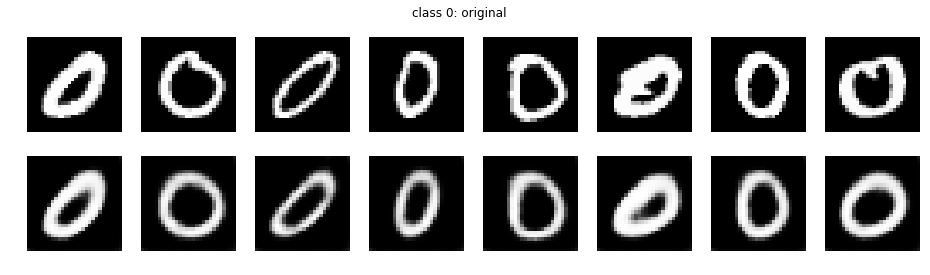

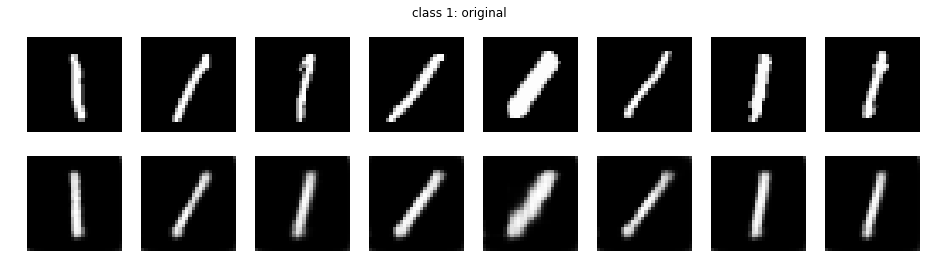

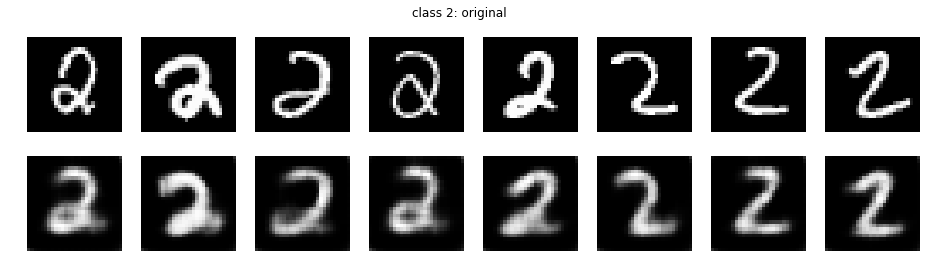

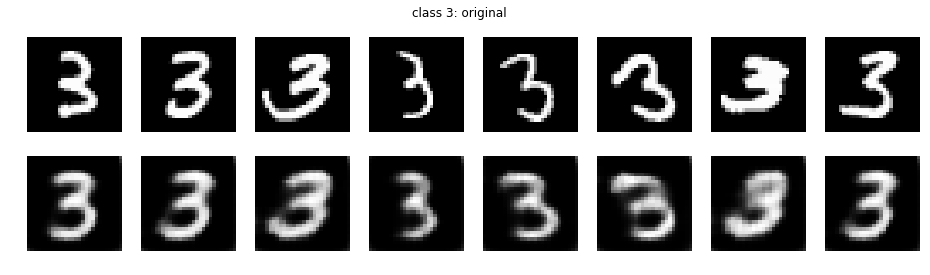

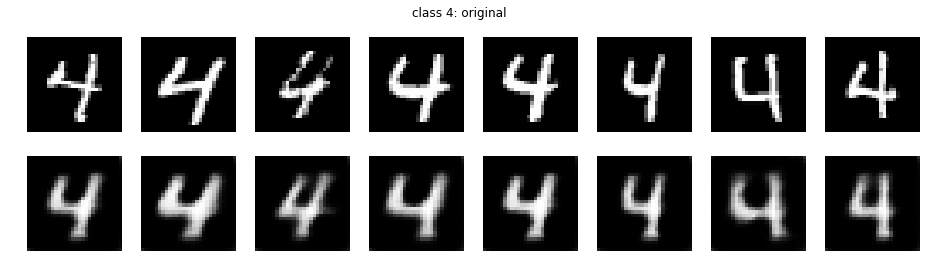

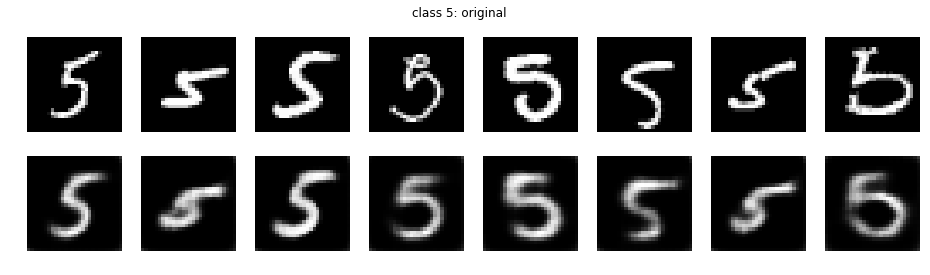

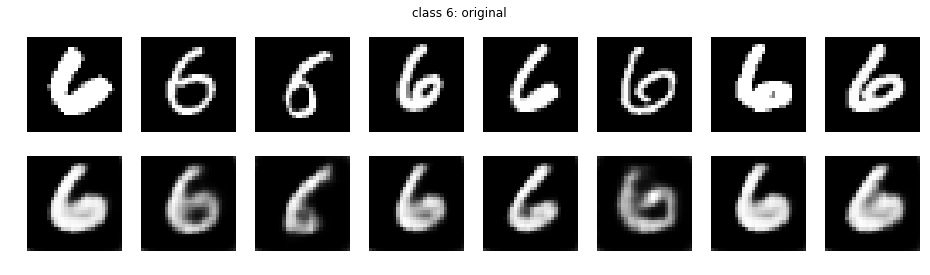

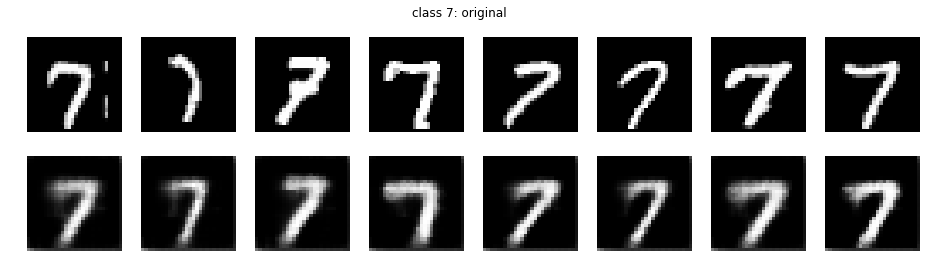

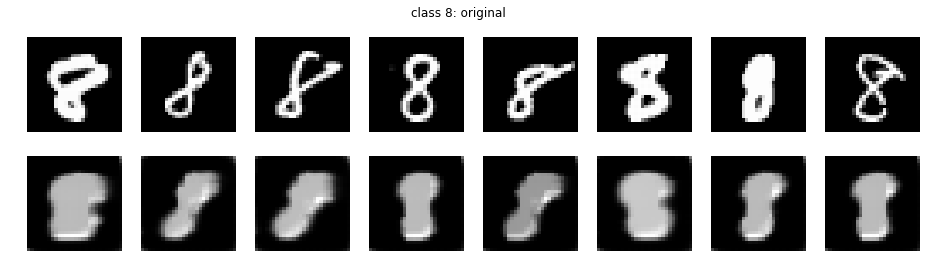

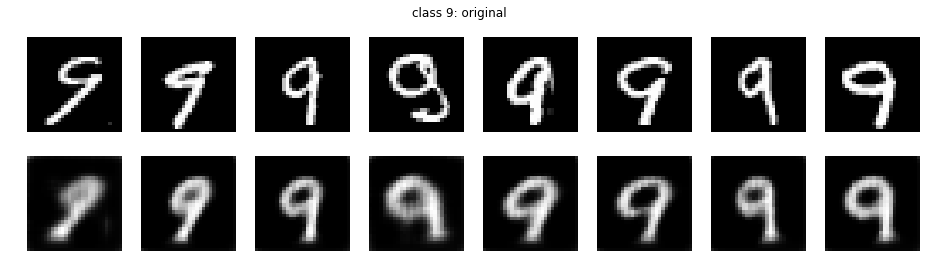

In [11]:
for (data_loader, model) in zip(test_loader_by_class, models_by_class):
  test_images, labels = iter(data_loader).next()
  test_images = test_images[:8, ...]
  test_batch = test_images.to(device)
  with th.no_grad():
    reconst_images, _, _ = model(test_batch)
  reconst_images = reconst_images.view(-1, 1, 28, 28)
  images = np.concatenate([test_images, reconst_images])
  visualize_images(images, title=f'class {labels[0]}: original',
                   rows=2, cols=8)

### Sampling z ~ N(0, 1)

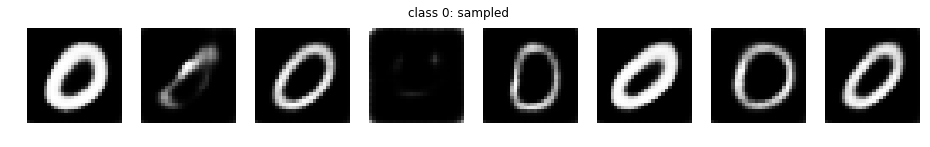

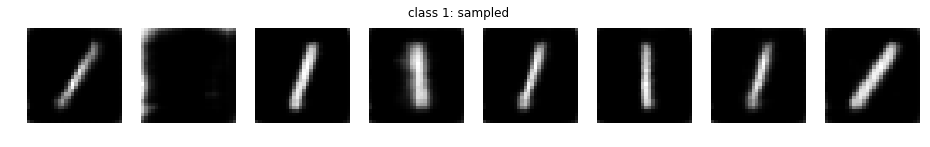

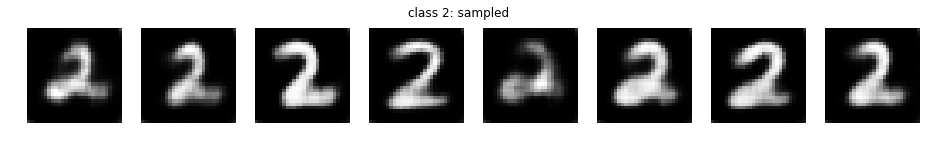

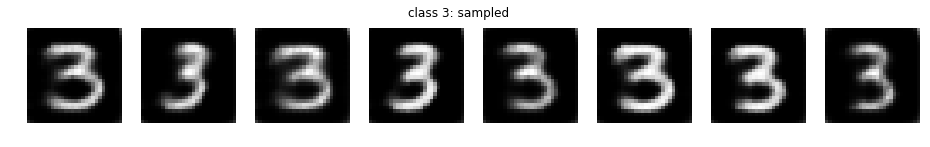

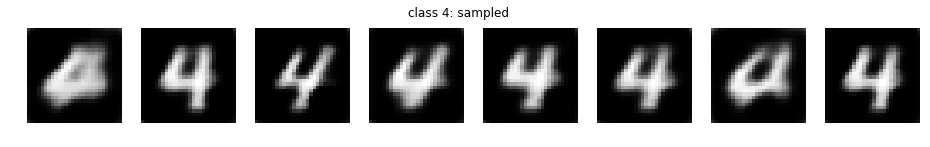

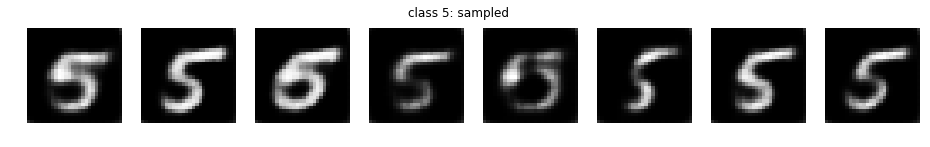

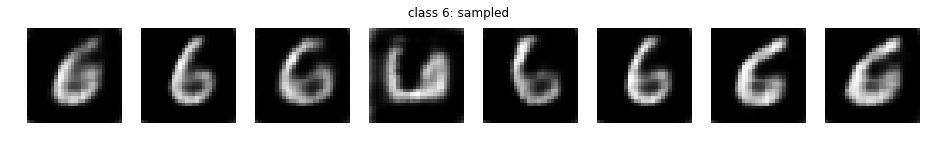

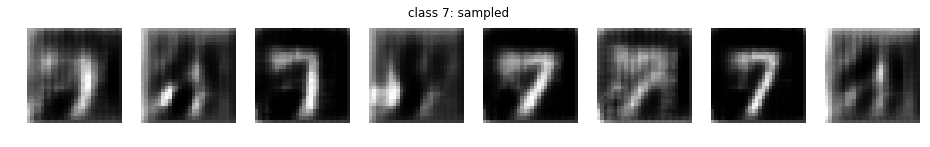

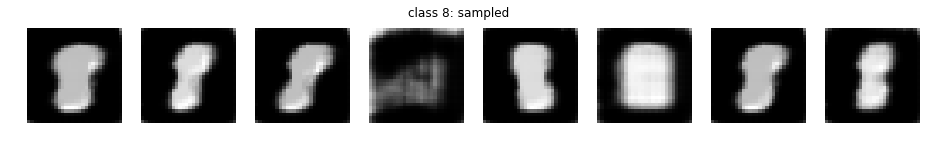

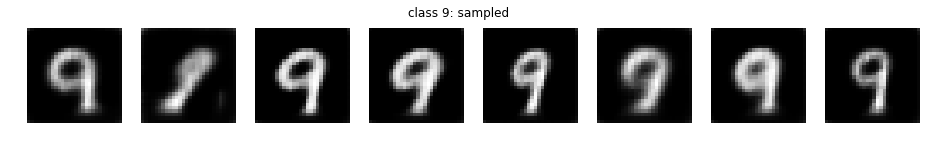

In [12]:
for i, model in enumerate(models_by_class):
  images = sample_images(model, num_samples=batch_size)
  visualize_images(images, title=f'class {i}: sampled', rows=1, cols=8)

### Reconstructing other classes

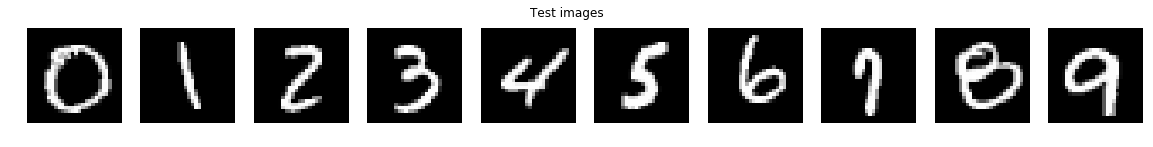

In [13]:
images_cm = [
    iter(data_loader).next()[0][:1, ...] for data_loader in test_loader_by_class
]
visualize_images(np.concatenate(images_cm), title=f'Test images',
                 rows=1, cols=10)

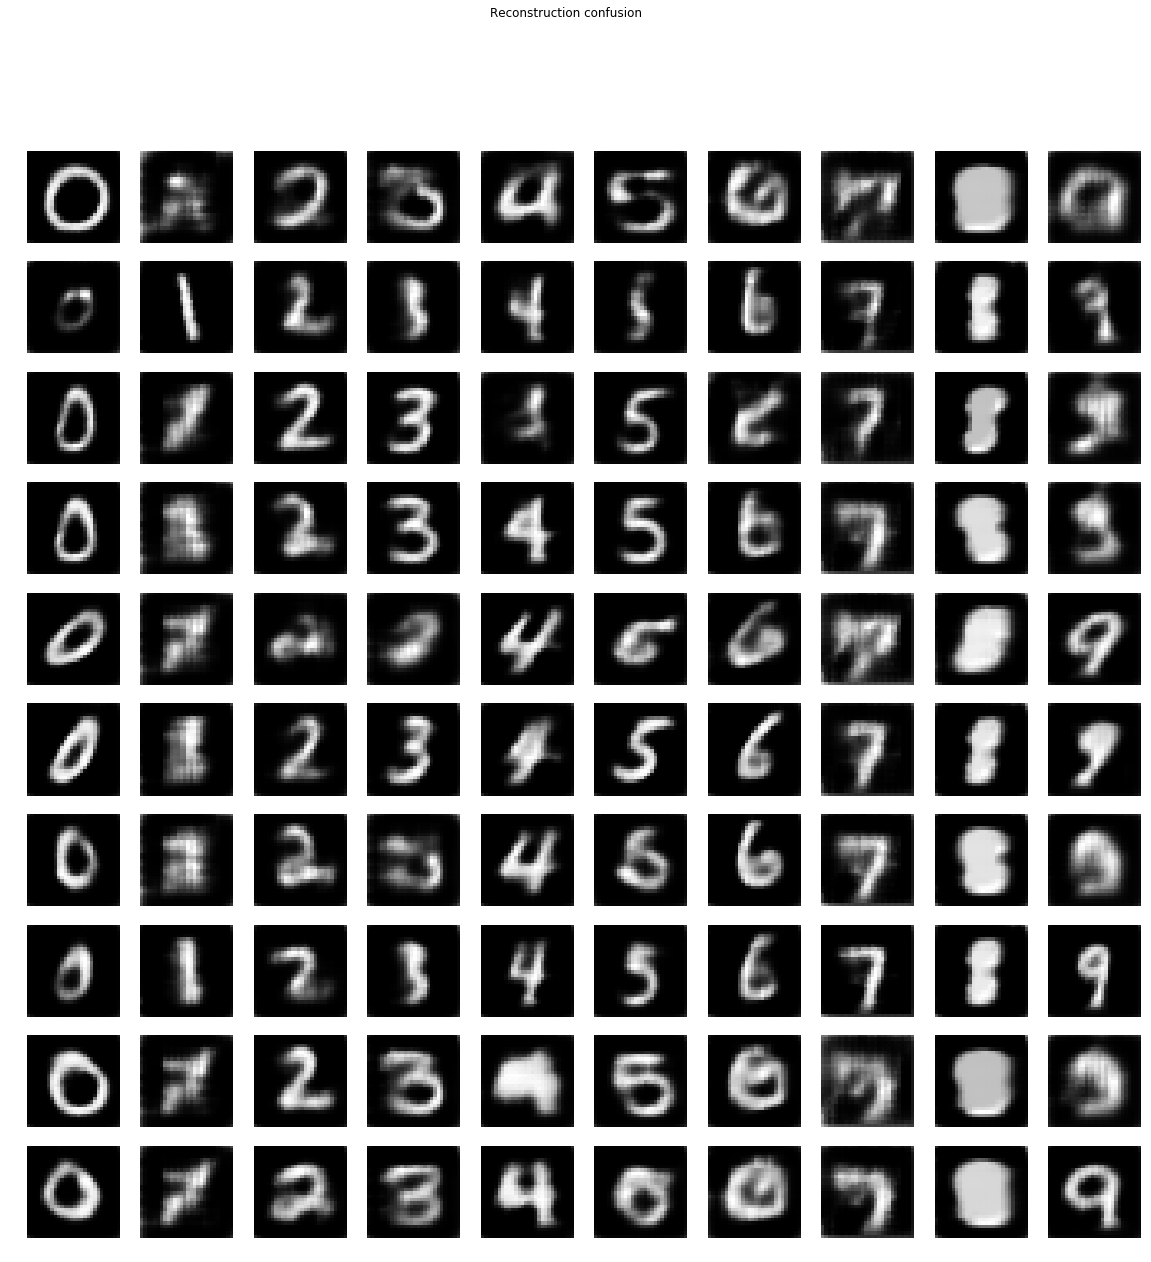

In [14]:
confusion_grid = []
for test_image in images_cm:
  for model in models_by_class:
    test_batch = test_image.to(device)
    with th.no_grad():
      reconst_images, _, _ = model(test_batch)
    reconst_images = reconst_images.view(-1, 1, 28, 28)
    #images = np.concatenate([test_image, reconst_images])
    confusion_grid.append(reconst_images)
    
confusion_grid = np.concatenate(confusion_grid)
visualize_images(confusion_grid, title=f'Reconstruction confusion',
                 rows=10, cols=10)

### Classification

In [34]:
class VaeClassifier:
  def __init__(self, models_by_class):
    self._models_by_class = models_by_class
    
  def __call__(self, x):
    x_reconsts = [model(x)[0] for model in self._models_by_class]
    log_probs = [self.log_prob(x, x_i) for x_i in x_reconsts]
    #print(log_probs)
    log_probs = th.stack(log_probs).t()
    #print(log_probs)
    return log_probs
  
  def log_prob(self, x, x_reconst):
    reconst_loss = thf.binary_cross_entropy(x_reconst, x, reduction='none')
    reconst_loss = th.sum(reconst_loss, dim=(-3, -2, -1))
    #kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #loss = reconst_loss + kl_div
    return -reconst_loss

classifier = VaeClassifier(models_by_class)  

errors = []
with th.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = classifier(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct_mask = (predicted == labels)
    correct += correct_mask.sum().item()
    
    errors.append(images[~correct_mask, ...])
  errors = th.cat(errors)
    
  accuracy = correct / total
  print(f'Accuracy of model on 10000 test images: {100 * accuracy:0.2f}%')

Accuracy of model on 10000 test images: 90.76%


In [35]:
errors.shape

torch.Size([924, 1, 28, 28])

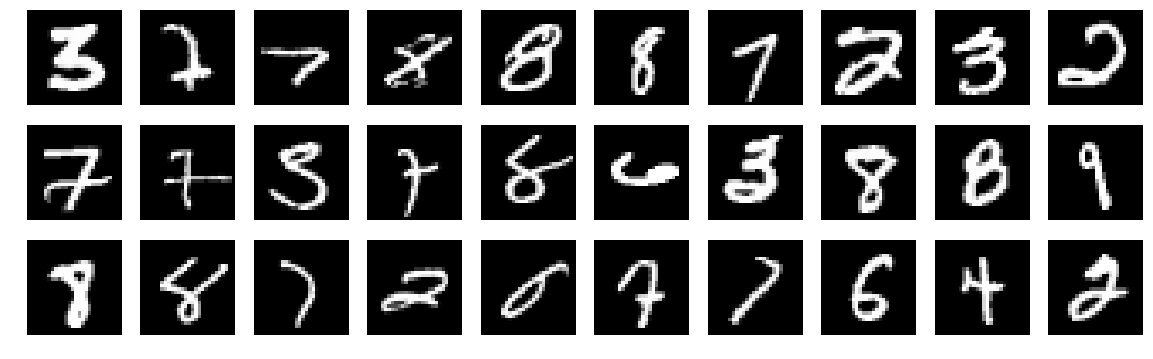

In [37]:
visualize_images(errors.cpu().numpy()[:30], rows=3, cols=10) 

Things to try


*   Verify that BCE gives reconstruction log_prob
*   Adjust log_prob by mean on the train set, for that class. Some classes seem harder than others to model
*   Improve encoder-decoders. Reconstructions in-class aren't very good yet
*   Play with latent size
*   Play with other prob density estimates (e.g. account for latent likelihood)


---

Longer term things to try


*   Train 1 model on all classes instead of 1 per class. Provide class as input. This models p(x, y) instead of p(x).





## Embedding t-SNE

In [0]:
def embed(model, data_loader):
  embeddings = []
  ys = []
  for x, y in data_loader:
    x = x.to(device)
    mu, logvar = model.encode(x)
    embeddings.append(mu.detach())
    ys.append(y.detach())
  return np.concatenate(embeddings), np.concatenate(ys)

train_embedding, train_y = embed(model, data_loader)
test_embedding, test_y = embed(model, test_loader)
print(train_embedding.shape, test_embedding.shape)

(60000, 20) (10000, 20)


In [0]:
def tsne(data, **kwargs):
  try:
    # https://github.com/DmitryUlyanov/Multicore-TSNE
    # ~50x speedup
    from MulticoreTSNE import MulticoreTSNE as TSNE
    tsne_model = TSNE(n_jobs=8, **kwargs)
  except ImportError:
    print('MulticoreTSNE not found. Falling back to sklearn.')
    from sklearn.manifold import TSNE
    kwargs['n_iter'] = kwargs.get('n_iter', 300)
    tsne_model =TSNE(**kwargs)
  return tsne_model.fit_transform(data)

def plot_tsne(data, labels):
  plt.scatter(data[:, 0], data[:, 1], c=labels,
              s=2, cmap=plt.cm.get_cmap('jet', 10))
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)

### Train (slow with n=60000)

In [0]:
train_tsne = tsne(train_embedding)
train_tsne.shape

(60000, 2)

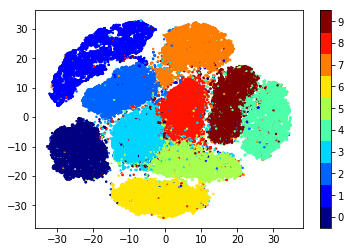

In [0]:
plot_tsne(train_tsne, train_y)

### Test

In [0]:
test_tsne = tsne(test_embedding)
test_tsne.shape

(10000, 2)

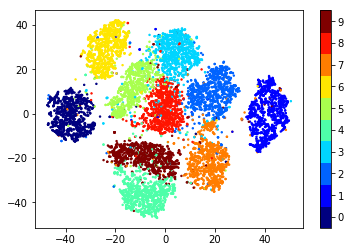

In [0]:
plot_tsne(test_tsne, test_y)

## Embedding arithmetic

In [0]:
import functools

embedding = train_embedding
label = train_y

reduce = functools.partial(np.mean, axis=0, keepdims=True)

def em(label):
  return train_embedding[train_y == label]

def em_r(label):
  return reduce(em(label))

def lerp(z_a, z_b, ts=tuple(np.arange(-0.2, 1.2 + 1e-6, 0.2))):
  zs = np.concatenate([(1 - t) * z_a + t * z_b for t in ts])
  images = model.decode_np(zs).detach()
  visualize_images(images,
                   sub_titles=['%.2f' % t for t in ts],
                   rows=1, cols=len(ts))

def arithmetic(a, b, c, ts=(0.1, 0.2, 0.3)): 
  a_mean, b_mean, c_mean = reduce(a), reduce(b), reduce(c)
  diff = a_mean - b_mean
  
  rs = [c_mean + t * diff for t in ts]
  zs = np.concatenate([a_mean, b_mean, c_mean] + rs + [diff])
  images = model.decode_np(zs).detach()
  
  rs_titles = ['c + %.1f * (a - b)' % t for t in ts]
  visualize_images(images,
                   sub_titles=['a', 'b', 'c'] + rs_titles + ['a - b'],
                   rows=1, cols=4 + len(ts))

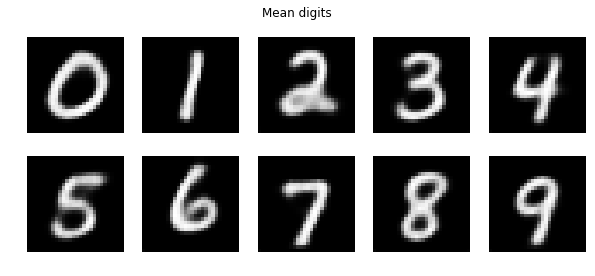

In [0]:
# Plot average of each digit
mean_digits_z = np.concatenate([reduce(em(i)) for i in range(10)])
mean_digits = model.decode_np(mean_digits_z).detach()
visualize_images(mean_digits, title='Mean digits', rows=2, cols=5)

### a - b + c = ?

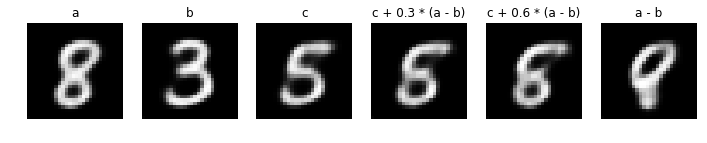

In [0]:
# 8 - 3 rounds out the left side of the digit.
arithmetic(em(8), em(3), em(5), ts=(0.3, 0.6))

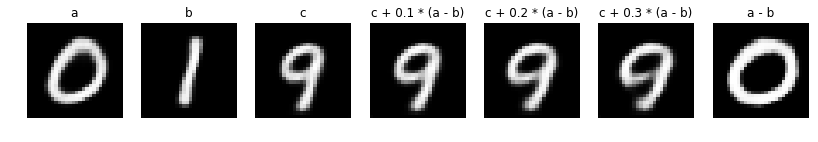

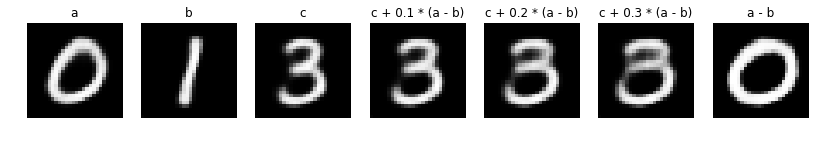

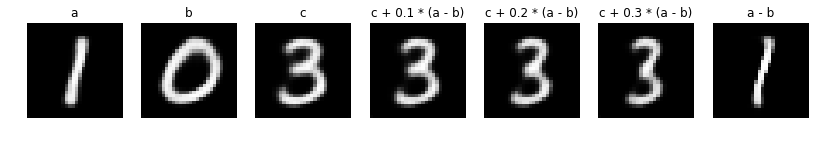

In [0]:
# 0 - 1 makes digits fatter.
arithmetic(em(0), em(1), em(9))
arithmetic(em(0), em(1), em(3))
arithmetic(em(1), em(0), em(3))

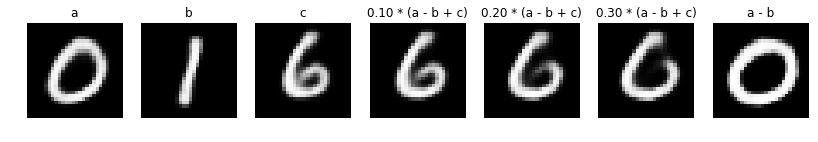

In [0]:
# 0 - 1 also makes digits rounder
arithmetic(em(0), em(1), em(6))

### Interpolation

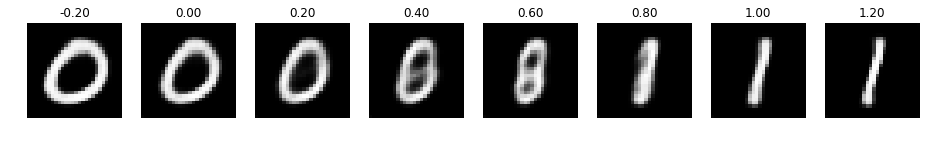

In [0]:
lerp(em_r(0), em_r(1))

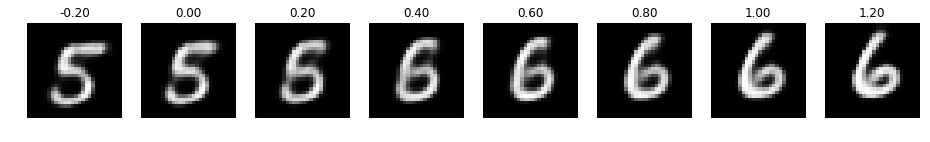

In [0]:
lerp(em_r(5), em_r(6))

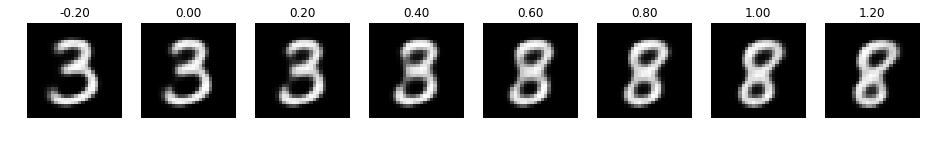

In [0]:
lerp(em_r(3), em_r(8))

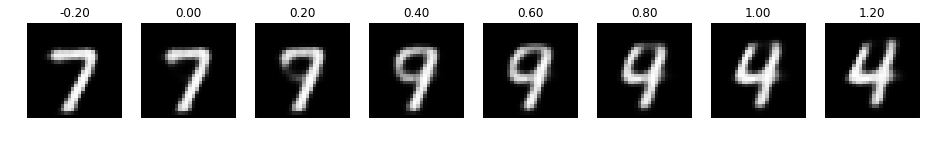

In [0]:
lerp(em_r(7), em_r(4))

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/vae.ckpt')